<a href="https://colab.research.google.com/github/SarthakNarayan/DL-and-ML/blob/master/googlecolab/Time_Series_Simple_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
%matplotlib inline

[0.         0.15707963 0.31415927 0.4712389  0.62831853 0.78539816
 0.9424778  1.09955743 1.25663706 1.41371669 1.57079633 1.72787596
 1.88495559 2.04203522 2.19911486 2.35619449 2.51327412 2.67035376
 2.82743339 2.98451302 3.14159265]
(21,)
(21, 1)


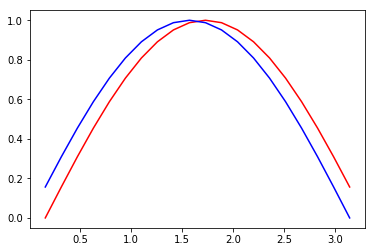

In [2]:
seq_length = 20
# It should have 20 values between 0 and pi
time_steps = np.linspace(0 , np.pi , seq_length+1)
print(time_steps)
data = np.sin(time_steps)
print(data.shape)
data.resize((seq_length+1 , 1))
print(data.shape)
# 21 numbers in the sequence so that both x and y are of same length
x = data[:-1]
y = data[1:]
plt.plot(time_steps[1:] , x , 'r' , label = 'Input X')
plt.plot(time_steps[1:] , y , 'b' , label = 'Target Y')
plt.show()

Link to rnn documentation <br/>
<https://pytorch.org/docs/stable/nn.html?highlight=rnn#torch.nn.RNN>




In [0]:
# defininf the network
class RNN(nn.Module):
    def __init__(self ,input_size , output_size , no_of_hidden_layers , n_layers):
        super(RNN , self).__init__()
        
        # we are storing the value of hidden layers so that we can use it in forward function
        self.no_of_hidden_layers = no_of_hidden_layers
        # We have sahped the input in such a way that batch size will be first
        self.rnn = nn.RNN(input_size , no_of_hidden_layers , n_layers , batch_first=True)
        self.fc = nn.Linear(no_of_hidden_layers , output_size)
        
    def forward(self , x , hidden):
        batch_size = x.shape[0]
        r_out , hidden = self.rnn(x , hidden)
        r_out = r_out.reshape(-1 , self.no_of_hidden_layers)
        output = self.fc(r_out)
        return output , hidden

# x is of the shape (batch , sequence , input_size)
# initial hidden state is None

In [21]:
# checking if all the dimensions are correct
rnn = RNN(input_size=1 , output_size=1 , no_of_hidden_layers = 20 , n_layers=2)
input_data = torch.Tensor(x)
print(input_data.shape)
input_data = input_data.reshape(1 , x.shape[0] , x.shape[1])
print(input_data.shape)
test_out , test_hidden = rnn(input_data , None)
print("Test output shape",test_out.shape)
print("Hidden layer shape",test_hidden.shape)

torch.Size([20, 1])
torch.Size([1, 20, 1])
Test output shape torch.Size([20, 1])
Hidden layer shape torch.Size([2, 1, 20])


In [57]:
# training the model
# since we are inputting and ouputting 1 sequence at a time
input_size = 1
output_size = 1
# no_of_hidden_layers is the number of features we expect to generate with our RNN
no_of_hidden_layers = 32
# n_layers=1 means we are not stacking any RNN layers
n_layers = 1
Rnn = RNN(input_size,output_size,no_of_hidden_layers,n_layers).cuda()
print(Rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [0]:
# since we are basically predicting coordinates we will use mse loss
torch.manual_seed(23)
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(Rnn.parameters() , lr = 1e-3)

def train(rnn , n_steps , print_every):
    # initial hidden state
    hidden = None
    # we use range because we need to iterate over something and it cannot be an integer
    for batch_no , step in enumerate(range(n_steps)):
        # preparing the data
        time_steps = np.linspace(step*np.pi , (step+1)*np.pi , seq_length+1)
        data = np.sin(time_steps)
        # resizing it since no of input features = 1
        data.resize((seq_length+1 , 1))
        # 21 numbers in the sequence so that both x and y are of same length
        x = data[:-1]
        y = data[1:]
        
        x_tensor = torch.Tensor(x).unsqueeze(dim = 0).cuda()
        y_tensor = torch.Tensor(y).cuda()
        
        output , hidden = rnn(x_tensor , hidden)
        hidden = hidden.data
        optimizer.zero_grad()
        loss = criterion(output , y_tensor)
        loss.backward()
        optimizer.step()
        output = output.cpu()
        
        if batch_no%print_every == 0:
            print("the loss is {}".format(loss.item()))
            plt.plot(time_steps[1:] , x , 'r.' , label = 'Input data')
            # since you cannot call numpy on variable that requires grad
            plt.plot(time_steps[1:] , output.data.numpy().flatten() , 'b.' , label = 'Output Data')
            plt.legend()
            plt.show()
    
    # incase you want to save the model
    print("The output shape is {}".format(output.shape))
    return rnn
        

the loss is 0.023679111152887344


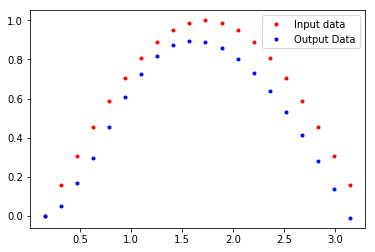

the loss is 3.422329609747976e-05


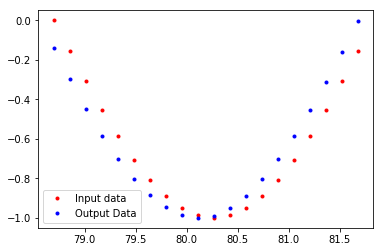

the loss is 3.077275323448703e-05


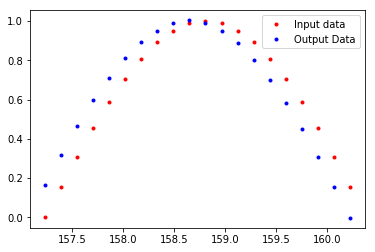

the loss is 6.492517513834173e-06


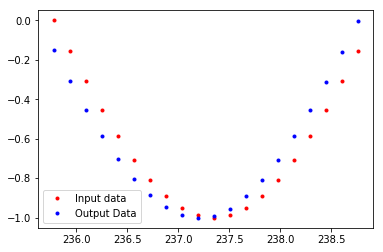

the loss is 6.964136446185876e-06


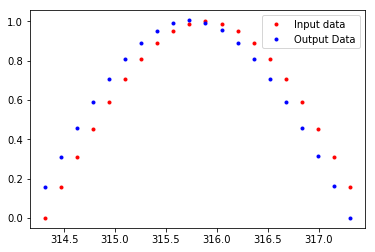

the loss is 4.293868187232874e-06


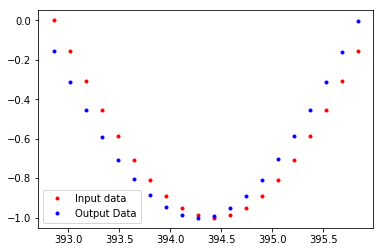

the loss is 5.5634691307204776e-06


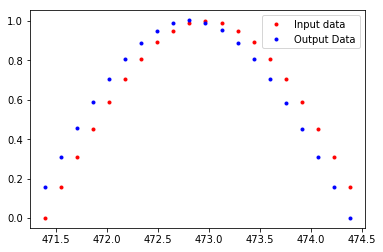

The output shape is torch.Size([20, 1])


In [76]:
# output data should always be 1 time step ahead
trained_rnn = train(Rnn , 175 , 25)